In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
def part_interaction(N,saut,P0,M,alpha,mu,m):

    sigma_inf_carre = lamb
    if m==1:
        sigma_inf_carre *=(1+alpha)/(1-alpha)
    else:
        sigma_inf_carre *= (5./9.+25./9.*(1+alpha)/(1-alpha))
    #mu: paramètre des poids G_p
    # Tirages de M x N v.a. suivant la loi normale 
    xi= np.random.normal(0,1,size=(M, N))   #N: horizon temporel (nombre de sauts)

    ###############################################################################
    ## En ponderant les trajectoires basses : Estimation via G(X)=e^{alpha X_k}
    ###############################################################################

    # X stocke TOUTES LES VALEURS pour chacune des M chaines, dans l'optique du calcul de G_p 
    Y = np.zeros((M,N))


    # On initialise avec P0*sqrt(N/T/sigma_inf_carre) + premier incrément gaussien
    Y[:,0] = P0*np.sqrt(N/T/sigma_inf_carre) + xi[:,0]
        
    facteurDroite = 1 #produit des moyennes des pondérations à chaque itération

    for k in range(N-1):
                
        weights = np.exp(-mu*Y[:,k])
        
        facteurDroite *= np.mean(weights)
        
        
        weights = weights/np.sum(weights)

        I = np.random.choice(np.arange(M),size=M,replace=True,p=weights)
        
        #sélection
        Y = Y[I,:]

        #mutation

        Y[:,k+1] = Y[:,k] +xi[:,k+1]
    #final_moyen=np.mean(Y[:,-1]) #sert pour ajuster mu en essayant d'obtenir un Y final proche de 0
    #print(final_moyen)
    tabFacteursGauche = np.exp(mu*np.sum(Y[:,:-1],axis=1)) #tableau des 1/(\prod_{k=0}^{N-2} G_k)
    proba_negatif = np.sum(tabFacteursGauche[np.min(Y,axis=1)<0])/M * facteurDroite
    return proba_negatif

In [2]:
%%time
#m=3
from tqdm.notebook import tqdm
M= int(1e6)
N=100
mu = 0.03
P0 = 35
T = 4*60*60
lamb = 1/300
N=100
alpha = -0.875
value_2 = np.array([1, 1, 1, 2, 2, 3])
saut_1 = lambda x: np.ones(shape=x) #correspond à m=1
saut_2 = lambda x: value_2[np.random.randint(low=6, size=x)] #correspond à m=3
#proba_negatif = part_interaction(N,saut_2_vect,P0,M,alpha,mu,3) 

L= 50
probas_negatif = np.zeros(L)
for l in tqdm(range(L)):
    probas_negatif[l] = part_interaction(N,saut_1, P0,M,alpha,mu,1)
R_IC= np.sqrt(np.var(probas_negatif)/L)*sps.t.ppf(0.975,df=L-1) #quantile de la loi de Student 
print("Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : {}+/- {}".format(np.mean(probas_negatif),R_IC))


#1e-14 pour M=10^4 mu = 0.03 N=100

KeyboardInterrupt: 

0.00022222222222222223
Quantile : 809.863027647084


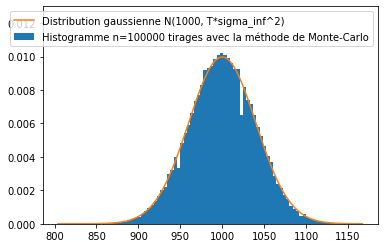

0.0024691358024691358
Quantile : 366.21009215694676


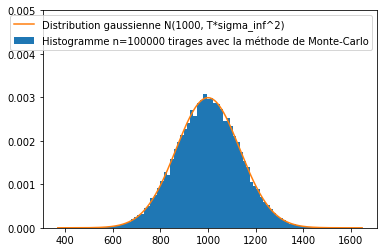

CPU times: user 1min 26s, sys: 1min 3s, total: 2min 29s
Wall time: 8min 23s


In [2]:
%%time
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

@jit(nopython=True, cache=False, parallel=True)
def quantiles_macro(N, signes, increments, P0):
    quantiles = np.zeros(len(N) - 1)
    for i in range(len(N) - 1):
        somme = P0
        signe = signes[N[i]]
        for j in range(N[i], N[i+1]):
            somme += signe * increments[j]
            signe *= signes[j+1]
        quantiles[i] = somme
    return quantiles
    

def Q3_limite_macro_quantile(lamb, T,saut,P0,M,alpha):
    # Sauts
    N = np.random.poisson(lamb*T, size=M + 1)
    N[0] = 0
    N = N.cumsum()
    
    increments = saut(N[-1] + 1)
    # Signes
    signes = -1 + 2 * np.random.binomial(1, (1 + alpha) / 2, size=N[-1] + 1) # 1 : rester le même signe
    signes[N[:-1]] = -1 + np.random.binomial(1, 0.5, size=M) * 2 # Début : -1 ou 1 de proba 1/2
    
    return quantiles_macro(N, signes, increments, P0)
from scipy.stats import norm
P0 = 35
T = 4*60*60
lamb = 1/300
N=100
alpha = -0.875
value_2 = np.array([1, 1, 1, 2, 2, 3])
saut_1 = lambda x: np.ones(shape=x) #correspond à m=1
saut_2 = lambda x: value_2[np.random.randint(low=6, size=x)] #correspond à m=3

for m in [1, 3]:
  sigma_inf = lamb
  if m==1:
      sigma_inf *=(1+alpha)/(1-alpha)
      saut = saut_1
      ylim = 0.013
  else:
      sigma_inf *= (5./9.+25./9.*(1+alpha)/(1-alpha))
      saut = saut_2
      ylim = 0.005
  print(sigma_inf)
  ans = Q3_limite_macro_quantile(1/300, 8*250*60*60, saut, 1000, int(1e5), -0.875)
  n = len(ans)
  T = 250 * 8 * 60 * 60

  print("Quantile : {}".format(norm.ppf(1e-6, loc=1000, scale=np.sqrt(sigma_inf * T))))

  x = np.linspace(ans.min(), ans.max(), 8000)
  n_colonnes = 2 * int(n ** (1. / 3.))
  plt.hist(ans, bins=n_colonnes, density=True, label="Histogramme n=%1.0f tirages avec la méthode de Monte-Carlo" %n)
  plt.plot(x, norm.pdf(x, loc=1000, scale=np.sqrt(sigma_inf * T)), label="Distribution gaussienne N(1000, T*sigma_inf^2)")
  plt.ylim(0, ylim)
  #plt.title("Convergence du prix final avec la loi gaussienne m = {}".format(m))
  plt.legend(loc="best")
  plt.savefig("limite_macro_m={}.png".format(m))
  plt.show()

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
## Calcul de IC pour les quantiles
from scipy.stats import binom
from math import ceil
def IC_quantile(quantiles, niveau):
    n = len(quantiles)
    quantiles = np.sort(quantiles)
    index_ = ceil(n * niveau) - 1
    niveau_inf = ceil(n * (niveau - 1.96 * np.sqrt(niveau * (1-niveau) / n))) - 1
    niveau_sup = ceil(n * (niveau + 1.96 * np.sqrt(niveau * (1-niveau) / n))) - 1
    q = quantiles[index_]
    print("Quantile au niveau {} = {}, avec intervalle de confiance = {}, {}".format(niveau, 
                                                                                     q, 
                                                                                     quantiles[niveau_inf], 
                                                                                     quantiles[niveau_sup]))

In [11]:
ans = []
for i in "abcde":
    ans.append(np.load("proba_m=" + str(m)+ i + ".npy"))
ans = np.array(ans).reshape(-1)
ans.shape
ans = np.sort(ans)

In [12]:
IC_quantile(ans, 1 - 1e-6)
IC_quantile(ans, 1e-6)

Quantile au niveau 0.999999 = 1925.0, avec intervalle de confiance = 1902.0, 1972.0
Quantile au niveau 1e-06 = 50.0, avec intervalle de confiance = 25.0, 83.0


In [31]:
value_2 = np.array([1, 1, 1, 2, 2, 3])
saut_1 = lambda x: np.ones(shape=x) #correspond à m=1
saut_2 = lambda x: value_2[np.random.randint(low=6, size=x)] #correspond à m=3
m = 1
if m == 3:
    saut = saut_2
else:
    saut = saut_1
ans = Q3_limite_macro_quantile(1/300, 8*250*60*60, saut, 1000, int(1e3), -0.875)

In [29]:
from numba import jit

@jit(nopython=True)
def quantiles_macro(N, signes, increments, P0):
    quantiles = np.zeros(len(N) - 1)
    for i in range(len(N) - 1):
        somme = P0
        signe = signes[N[i]]
        for j in range(N[i], N[i+1]):
            somme += signe * increments[j]
            signe *= signes[j+1]
        quantiles[i] = somme
    return quantiles
    

def Q3_limite_macro_quantile(lamb, T,saut,P0,M,alpha):
    # Sauts
    N = np.random.poisson(lamb*T, size=M + 1)
    N[0] = 0
    N = N.cumsum()
    
    increments = saut(N[-1] + 1)
    # Signes
    signes = -1 + 2 * np.random.binomial(1, (1 + alpha) / 2, size=N[-1] + 1) # 1 : rester le même signe
    signes[N[:-1]] = -1 + np.random.binomial(1, 0.5, size=M) * 2 # Début : -1 ou 1 de proba 1/2
    
    return quantiles_macro(N, signes, increments, P0)

from scipy.stats import norm
sigma_inf = 1/300
alpha = -0.875
if m==1:
    sigma_inf *=(1+alpha)/(1-alpha)
else:
    sigma_inf *= (5./9.+25./9.*(1+alpha)/(1-alpha))
print(sigma_inf)
n = len(ans)
T = 250 * 8 * 60 * 60

print("Quantile : {}".format(norm.ppf(1e-6, loc=1000, scale=np.sqrt(sigma_inf * T))))

x = np.linspace(ans.min(), ans.max(), 8000)
n_colonnes = 2 * int(n ** (1. / 3.))
plt.hist(ans, bins=n_colonnes, density=True, label="Histogramme n=%1.0f tirages avec la méthode de Monte-Carlo" %n)
plt.plot(x, norm.pdf(x, loc=1000, scale=np.sqrt(sigma_inf * T)), label="Distribution gaussian N(1000, sigma_inf*sqrt(T))")
#plt.ylim(0, 0.0009)
plt.title("Convergence m = {}".format(m))
plt.legend(loc="best")